In [93]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report, f1_score
from sklearn.svm import SVC, LinearSVC
import imblearn
from collections import Counter

In [94]:
df = pd.read_excel("~/Downloads/Crunchbase_2005-2013.xls", index_col = 'Organization Name', na_values=['nan'])
eda_df = df
eda_df = eda_df[eda_df.columns[eda_df.isnull().mean() < 0.5]]
eda_df['Class'] = 0


eda_df["Last Funding Date"] = pd.DatetimeIndex(pd.to_datetime(eda_df['Last Funding Date'], unit='s')).year
eda_df["Founded Date"] = pd.DatetimeIndex(pd.to_datetime(eda_df['Founded Date'], unit='s')).year
eda_df['Acquisition Status'] = eda_df['Acquisition Status'].astype(str)
eda_df['Industry Groups'] = eda_df['Industry Groups'].astype(str)

eda_df['Estimated Revenue Range'] = eda_df['Estimated Revenue Range'].astype(str)
eda_df['Estimated Revenue Range'] = eda_df['Estimated Revenue Range'].replace('nan', np.NaN).fillna(' ')
eda_df.loc[(eda_df["Last Funding Date"] >= 2018) | (eda_df["Number of Funding Rounds"] > 7) | 
       (eda_df["IPO Status"] == "Public"),
       'Class'] = 1
for i,j in eda_df.iterrows():
    loc = j['Headquarters Location'].split(',')[1]
    eda_df.loc[i,'Headquarters Location'] = j['Headquarters Location'].split(',')[1]
eda_df['Top 5 Investors'] = eda_df['Top 5 Investors'].str.split(',')
eda_df = eda_df.explode('Top 5 Investors')
eda_df['Industries'] = eda_df['Industries'].str.split(',')
eda_df = eda_df.explode('Industries')
eda_df.reset_index(inplace=True)
# eda_df.drop(['index'],axis=1,inplace=True)
eda_df=eda_df.fillna(eda_df.mode().iloc[0])

<ipython-input-94-f07e5cfe960c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_df['Class'] = 0
<ipython-input-94-f07e5cfe960c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_df["Last Funding Date"] = pd.DatetimeIndex(pd.to_datetime(eda_df['Last Funding Date'], unit='s')).year
<ipython-input-94-f07e5cfe960c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [95]:
eda_df.drop_duplicates(subset='Organization Name',inplace=True,keep='first')



In [96]:
cols = ['Organization Name','Class','IPO Status','Funding Status','Number of Funding Rounds','Last Funding Amount',
 'Founded Date','Last Funding Type','Total Funding Amount','Number of Lead Investors','Number of Investors','Industries',
 'Acquisition Status',
 
 
 'Last Funding Date','BuiltWith - Active Tech Count',
 'Announced Date']
sample_df=eda_df[cols]

In [97]:
sample_df_no_fund = sample_df.loc[:,sample_df.columns!='Total Funding Amount']
sample_df['Announced Date'] = sample_df['Announced Date'].apply(lambda x:x.year )
sample_df['Acquired?'] = sample_df.apply(lambda x: 1 if 'Acquired' in x['Acquisition Status'] else 0,axis=1)
from datetime import datetime
sample_df['Last funding diff'] = sample_df['Last Funding Date'] - sample_df['Announced Date']
sample_df['Age'] = datetime.now().year - sample_df['Founded Date']
sample_df.drop('Founded Date',axis=1,inplace=True)
sample_df.drop('Acquisition Status',axis=1,inplace=True)

<ipython-input-97-1c14b7508516>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['Announced Date'] = sample_df['Announced Date'].apply(lambda x:x.year )
<ipython-input-97-1c14b7508516>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['Acquired?'] = sample_df.apply(lambda x: 1 if 'Acquired' in x['Acquisition Status'] else 0,axis=1)
<ipython-input-97-1c14b7508516>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [98]:
sample_df.set_index('Organization Name',inplace=True)
sample_df.drop(['Announced Date','Last funding diff'],axis=1,inplace=True)
sample_df.drop('Class',axis=1,inplace=True)
enc = OneHotEncoder(sparse=False)

IPO_status = sample_df[["IPO Status"]]
Acquisition_status = sample_df[["Funding Status"]]
Estimated_Revenue = sample_df[["Industries"]]
fund_type = sample_df[["Last Funding Type"]]


IPO_1hot = enc.fit_transform(IPO_status)
Acquisition_status_1hot = enc.fit_transform(Acquisition_status)
Revenue_1hot = enc.fit_transform(Estimated_Revenue)
fund_1hot = enc.fit_transform(fund_type)



IPO_df = pd.DataFrame(columns = ['Delisted', 'Private', 'Public'], data = IPO_1hot, index = sample_df.index)
Acquisition_df = pd.DataFrame(columns = sample_df["Funding Status"].unique(), data = Acquisition_status_1hot, index = sample_df.index)
ind_df = pd.DataFrame(columns = sample_df["Industries"].unique(), data = Revenue_1hot, index = sample_df.index)
fund_df = pd.DataFrame(columns = sample_df["Last Funding Type"].unique(), data = fund_1hot, index = sample_df.index)

sample_df = sample_df.drop(['IPO Status', 'Funding Status', 'Industries', "Last Funding Type"], axis=1)
sample_df = pd.concat([IPO_df, sample_df], axis=1)
sample_df = pd.concat([Acquisition_df, sample_df], axis=1)
sample_df = pd.concat([fund_df, sample_df], axis=1)
sample_df = pd.concat([fund_type, sample_df], axis=1)







In [99]:
sample_df = sample_df.drop(["Last Funding Type"], axis=1)

In [100]:
sample_df

,Series F,Series E,Series G,Post-IPO Equity,Grant,Venture - Series Unknown,Private Equity,Secondary Market,Series A,Series B,...,Public,Number of Funding Rounds,Last Funding Amount,Total Funding Amount,Number of Lead Investors,Number of Investors,Last Funding Date,BuiltWith - Active Tech Count,Acquired?,Age
Organization Name,,,,,,,,,,,,,,,,,,,,,
UiPath,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8,750000000.0,1.991000e+09,6.0,27.0,2021,159.0,0,16
Reddit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7,367949748.0,9.190497e+08,3.0,25.0,2021,8.0,1,16
Workday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,6,85000000.0,2.305500e+08,6.0,8.0,2011,55.0,0,16
Box,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,12,150000000.0,5.589500e+08,6.0,24.0,2014,80.0,0,16
Zillow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,5,4128000.0,9.662798e+07,4.0,4.0,2012,85.0,0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ActiveNet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,5000000.0,1.000000e+06,1.0,1.0,2014,1.0,1,8
FriedWire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,5000000.0,1.000000e+06,1.0,1.0,2000,6.0,1,8
ReferBright,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,5000000.0,1.000000e+06,1.0,2.0,2013,7.0,1,8


In [101]:
sample_df.drop_duplicates(inplace=True)
X=sample_df

In [102]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
X = X.loc[:,~X.columns.duplicated()]
X = X.loc[:, X.columns != 'Acquired?']
y = sample_df['Acquired?']
from imblearn.under_sampling import RandomUnderSampler



rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)
print(len(X_resampled),len(y_resampled))

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.30, random_state = 2, shuffle = True)



3738 3738


In [103]:
#Decision Matrix Function
def confusion_matrix_plot(conf_mat):
    n = len(conf_mat)
    plt.imshow(conf_mat, cmap='Blues', extent=[-0.5, n-0.5, -0.5, n-0.5])
    
    for i in range(n):
        for j in range(n):
            plt.text(i, j, conf_mat[n-j-1, i], ha='center', va='center')
    
    plt.colorbar()
    plt.xticks(range(n))
    plt.yticks(range(n), range(n-1, -1, -1))
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.plot

In [104]:
final_results = pd.DataFrame(index = ["Training Accuracy", "Test Accuracy", 'Training Recall Score', "Test Recall Score"])
target_names = ['Fail (0)', 'Sucess (1)']

## Random Forest

In [105]:
clf  = RandomForestClassifier(oob_score = True, bootstrap=True)

clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Training Accuracy:", clf.score(X_train, y_train))
print("Test Accuracy:", clf.score(X_test, y_test))

print("Training", classification_report(y_train, y_pred_train, target_names=target_names))
print("Test", classification_report(y_test, y_pred_test, target_names=target_names))


final_results["random_forest"] = [clf.score(X_train, y_train), clf.score(X_test, y_test), recall_score(y_train, y_pred_train), recall_score(y_test, y_pred_test)]

Training Accuracy: 1.0
Test Accuracy: 0.8761140819964349
Training               precision    recall  f1-score   support

    Fail (0)       1.00      1.00      1.00      1315
  Sucess (1)       1.00      1.00      1.00      1301

    accuracy                           1.00      2616
   macro avg       1.00      1.00      1.00      2616
weighted avg       1.00      1.00      1.00      2616

Test               precision    recall  f1-score   support

    Fail (0)       0.89      0.85      0.87       554
  Sucess (1)       0.86      0.90      0.88       568

    accuracy                           0.88      1122
   macro avg       0.88      0.88      0.88      1122
weighted avg       0.88      0.88      0.88      1122



Training Confusion Matrix
Training Precision: 1.0 Training Recall: 1.0
              precision    recall  f1-score   support

    Fail (0)       1.00      1.00      1.00      1315
  Sucess (1)       1.00      1.00      1.00      1301

    accuracy                           1.00      2616
   macro avg       1.00      1.00      1.00      2616
weighted avg       1.00      1.00      1.00      2616



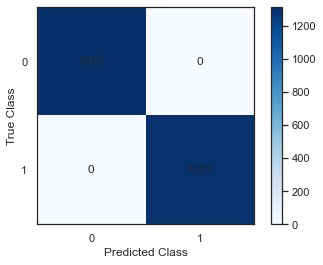

In [106]:
conf_mat_train = confusion_matrix(y_train, y_pred_train)
conf_mat_test = confusion_matrix(y_test, y_pred_test)

print("Training Confusion Matrix")
confusion_matrix_plot(conf_mat_train)
print(f"Training Precision: {round(precision_score(y_train, y_pred_train),4)} Training Recall: {round(recall_score(y_train, y_pred_train),4)}")
target_names = ['Fail (0)', 'Sucess (1)']
print(classification_report(y_train, y_pred_train, target_names=target_names))

Test Confusion Matrix
Test Precision: 0.8605 Test Recall: 0.9014
              precision    recall  f1-score   support

    Fail (0)       0.89      0.85      0.87       554
  Sucess (1)       0.86      0.90      0.88       568

    accuracy                           0.88      1122
   macro avg       0.88      0.88      0.88      1122
weighted avg       0.88      0.88      0.88      1122



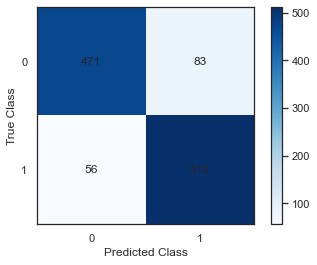

In [107]:
print("Test Confusion Matrix")
confusion_matrix_plot(conf_mat_test)
print(f"Test Precision: {round(precision_score(y_test, y_pred_test),4)} Test Recall: {round(recall_score(y_test, y_pred_test),4)}")
print(classification_report(y_test, y_pred_test, target_names=target_names))

## Logistic Regression

In [108]:
clf4  = LogisticRegression()

clf4.fit(X_train, y_train)
y_pred_train4 = clf4.predict(X_train)
y_pred_test4 = clf4.predict(X_test)

print("Training Accuracy:", clf4.score(X_train, y_train))
print("Test Accuracy:", clf4.score(X_test, y_test))

print("Training", classification_report(y_train, y_pred_train4, target_names=target_names))
print("Test", classification_report(y_test, y_pred_test4, target_names=target_names))

final_results["Logistic Regression"] = [clf4.score(X_train, y_train), clf4.score(X_test, y_test), recall_score(y_train, y_pred_train9), recall_score(y_test, y_pred_test9)]

Training Accuracy: 0.5026758409785933
Test Accuracy: 0.49376114081996436
Training               precision    recall  f1-score   support

    Fail (0)       0.50      1.00      0.67      1315
  Sucess (1)       0.00      0.00      0.00      1301

    accuracy                           0.50      2616
   macro avg       0.25      0.50      0.33      2616
weighted avg       0.25      0.50      0.34      2616

Test               precision    recall  f1-score   support

    Fail (0)       0.49      1.00      0.66       554
  Sucess (1)       0.00      0.00      0.00       568

    accuracy                           0.49      1122
   macro avg       0.25      0.50      0.33      1122
weighted avg       0.24      0.49      0.33      1122



/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/my

In [117]:
conf_mat_train = confusion_matrix(y_train, y_pred_train4)
conf_mat_test = confusion_matrix(y_test, y_pred_test4)

print(f"Training Precision: {round(precision_score(y_train, y_pred_train),4)} Training Recall: {round(recall_score(y_train, y_pred_train),4)}")
target_names = ['Fail (0)', 'Sucess (1)']
print(classification_report(y_train, y_pred_train, target_names=target_names))

Training Precision: 1.0 Training Recall: 1.0
              precision    recall  f1-score   support

    Fail (0)       1.00      1.00      1.00      1315
  Sucess (1)       1.00      1.00      1.00      1301

    accuracy                           1.00      2616
   macro avg       1.00      1.00      1.00      2616
weighted avg       1.00      1.00      1.00      2616



## AdaBoost

In [110]:
clf5  = AdaBoostClassifier(n_estimators=100)

clf5.fit(X_train, y_train)
y_pred_train5 = clf5.predict(X_train)
y_pred_test5 = clf5.predict(X_test)

print("Training", classification_report(y_train, y_pred_train5, target_names=target_names))
print("Test", classification_report(y_test, y_pred_test5, target_names=target_names))

final_results["AdaBoost"] = [clf5.score(X_train, y_train), clf5.score(X_test, y_test), recall_score(y_train, y_pred_train5), recall_score(y_test, y_pred_test5)]

Training               precision    recall  f1-score   support

    Fail (0)       0.93      0.91      0.92      1315
  Sucess (1)       0.91      0.94      0.92      1301

    accuracy                           0.92      2616
   macro avg       0.92      0.92      0.92      2616
weighted avg       0.92      0.92      0.92      2616

Test               precision    recall  f1-score   support

    Fail (0)       0.88      0.87      0.87       554
  Sucess (1)       0.87      0.88      0.88       568

    accuracy                           0.88      1122
   macro avg       0.88      0.88      0.88      1122
weighted avg       0.88      0.88      0.88      1122



## Gradient Boosting

In [111]:
clf6  = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=0)

clf6.fit(X_train, y_train)
y_pred_train6 = clf6.predict(X_train)
y_pred_test6 = clf6.predict(X_test)

print("Training", classification_report(y_train, y_pred_train6, target_names=target_names))
print("Test", classification_report(y_test, y_pred_test6, target_names=target_names))

final_results["Gradient Boost"] = [clf6.score(X_train, y_train), clf6.score(X_test, y_test), recall_score(y_train, y_pred_train6), recall_score(y_test, y_pred_test6)]

Training               precision    recall  f1-score   support

    Fail (0)       0.93      0.91      0.92      1315
  Sucess (1)       0.91      0.94      0.92      1301

    accuracy                           0.92      2616
   macro avg       0.92      0.92      0.92      2616
weighted avg       0.92      0.92      0.92      2616

Test               precision    recall  f1-score   support

    Fail (0)       0.88      0.87      0.88       554
  Sucess (1)       0.88      0.89      0.88       568

    accuracy                           0.88      1122
   macro avg       0.88      0.88      0.88      1122
weighted avg       0.88      0.88      0.88      1122



## KNN

In [112]:
clf7  = KNeighborsClassifier(n_neighbors=7)

clf7.fit(X_train, y_train)
y_pred_train7 = clf7.predict(X_train)
y_pred_test7 = clf7.predict(X_test)

print("Training", classification_report(y_train, y_pred_train7, target_names=target_names))
print("Test", classification_report(y_test, y_pred_test7, target_names=target_names))

final_results["KNN"] = [clf7.score(X_train, y_train), clf7.score(X_test, y_test), recall_score(y_train, y_pred_train7), recall_score(y_test, y_pred_test7)]

Training               precision    recall  f1-score   support

    Fail (0)       0.72      0.70      0.71      1315
  Sucess (1)       0.70      0.72      0.71      1301

    accuracy                           0.71      2616
   macro avg       0.71      0.71      0.71      2616
weighted avg       0.71      0.71      0.71      2616

Test               precision    recall  f1-score   support

    Fail (0)       0.61      0.57      0.59       554
  Sucess (1)       0.61      0.65      0.63       568

    accuracy                           0.61      1122
   macro avg       0.61      0.61      0.61      1122
weighted avg       0.61      0.61      0.61      1122



## Hard voting

In [113]:
eclf = VotingClassifier(
    estimators=[('rf', clf),('ada',clf5),('gb',clf6),('knn',clf7)],
    voting='hard')

eclf.fit(X_train, y_train)
y_pred_train8 = eclf.predict(X_train)
y_pred_test8 = eclf.predict(X_test)

print("Training", classification_report(y_train, y_pred_train8, target_names=target_names))
print("Test", classification_report(y_test, y_pred_test8, target_names=target_names))

final_results["Ensemble Hard Voting"] = [eclf.score(X_train, y_train), eclf.score(X_test, y_test), recall_score(y_train, y_pred_train8), recall_score(y_test, y_pred_test8)]

Training               precision    recall  f1-score   support

    Fail (0)       0.94      0.96      0.95      1315
  Sucess (1)       0.96      0.94      0.95      1301

    accuracy                           0.95      2616
   macro avg       0.95      0.95      0.95      2616
weighted avg       0.95      0.95      0.95      2616

Test               precision    recall  f1-score   support

    Fail (0)       0.88      0.88      0.88       554
  Sucess (1)       0.89      0.88      0.88       568

    accuracy                           0.88      1122
   macro avg       0.88      0.88      0.88      1122
weighted avg       0.88      0.88      0.88      1122



## Soft Voting

In [114]:
#linearsvc cant predict probabilities
eclf2 = VotingClassifier(
    estimators=[('rf', clf),('ada',clf5),('gb',clf6),('knn',clf7)],
    voting='soft')

eclf2.fit(X_train, y_train)
y_pred_train9 = eclf2.predict(X_train)
y_pred_test9 = eclf2.predict(X_test)

print("Training", classification_report(y_train, y_pred_train9, target_names=target_names))
print("Test", classification_report(y_test, y_pred_test9, target_names=target_names))

final_results["Ensemble Soft Voting"] = [clf.score(X_train, y_train), clf.score(X_test, y_test), recall_score(y_train, y_pred_train9), recall_score(y_test, y_pred_test9)]

Training               precision    recall  f1-score   support

    Fail (0)       0.99      0.97      0.98      1315
  Sucess (1)       0.97      0.99      0.98      1301

    accuracy                           0.98      2616
   macro avg       0.98      0.98      0.98      2616
weighted avg       0.98      0.98      0.98      2616

Test               precision    recall  f1-score   support

    Fail (0)       0.90      0.87      0.89       554
  Sucess (1)       0.88      0.90      0.89       568

    accuracy                           0.89      1122
   macro avg       0.89      0.89      0.89      1122
weighted avg       0.89      0.89      0.89      1122



## XGBoost

In [115]:
from xgboost import XGBClassifier
clf8 = XGBClassifier()
clf8.fit(X_train, y_train)
	
y_pred_train77 = clf8.predict(X_train)
y_pred_test77 = clf8.predict(X_test)

print("Training", classification_report(y_train, y_pred_train77, target_names=target_names))
print("Test", classification_report(y_test, y_pred_test77, target_names=target_names))

final_results["XGB"] = [clf8.score(X_train, y_train), clf8.score(X_test, y_test), recall_score(y_train, y_pred_train77), recall_score(y_test, y_pred_test77)]

[20:56:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614844528294/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training               precision    recall  f1-score   support

    Fail (0)       1.00      1.00      1.00      1315
  Sucess (1)       1.00      1.00      1.00      1301

    accuracy                           1.00      2616
   macro avg       1.00      1.00      1.00      2616
weighted avg       1.00      1.00      1.00      2616

Test               precision    recall  f1-score   support

    Fail (0)       0.87      0.85      0.86       554
  Sucess (1)       0.85      0.87      0.86       568

    accuracy                           0.86      1122
   macro avg       0.86      0.86      0.86      1122
weighted avg       0.86      0.86      0.86      1122



In [116]:
final_results

,random_forest,Logistic Regression,AdaBoost,Gradient Boost,KNN,Ensemble Hard Voting,Ensemble Soft Voting,XGB
Training Accuracy,1.000000,0.502676,0.921254,0.921254,0.709480,0.949159,1.000000,0.999235
Test Accuracy,0.876114,0.493761,0.875223,0.878788,0.608734,0.881462,0.876114,0.859180
Training Recall Score,1.000000,0.986933,0.936203,0.936203,0.722521,0.935434,0.988470,0.999231
Test Recall Score,0.901408,0.906690,0.883803,0.887324,0.646127,0.878521,0.903169,0.871479
